##### 

# Digging into Distributions


Look at specific genes in specific cell types: marker genes, perhaps? How do the distribution of counts change between cell types? 

Can I identify any parameters that are differentially expressed between cell types while the average levels of mRNA/nRNA are still similar? Probably not. 

In [60]:
# System
import sys
sys.path.insert(0, '../BIVI/')

# Math
import numpy as np
import torch
device = 'cuda'
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
# colors
import matplotlib.colors as mcolors
sns.color_palette("viridis", as_cmap=True)

# scvi
import anndata
import scanpy as sc

from distributions import log_prob_NBuncorr, log_prob_poisson, log_prob_NBcorr
from nnNB_module import log_prob_nnNB

In [156]:
# load in data

# open a file, where you stored the pickled data
# name = 'bursty_20ct_many'
# data_dir = '../../data/simulated_data/'


# change name to look at different datasets 
name = 'B08_processed_hv'
data_dir = '../../data/allen/'

results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
data = 'not_simulated'

if data == 'simulated':
    simulated_params = np.load(f'../../data/simulated_data/{name}_params.npy')
else:
    simulated_params = None

results_dict = pickle.load(results_file)
results_file.close()

# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata.var_names_make_unique()

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

    
cell_types = results_dict.pop('Cell Type')

if data == 'not_simulated':
    
    cell_range = range(len(cell_types.unique()))
    cell_dict = {cell : i for i,cell in enumerate(cell_types.unique())}
    cluster_assignments = np.array([cell_dict[ct] for ct in cell_types])
    print(len(cluster_assignments))
    
else:
    cluster_assignments = np.array([int(ct[2:]) for ct in cell_types])
    
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

# anndata objects for spliced and unspliced counts
adata_s = adata[:,adata.var['Spliced']==1].copy()    
adata_u = adata[:,adata.var['Spliced']==0].copy()

6454


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [180]:
cluster_labels = np.unique(np.array(adata.obs['subclass_label'].tolist()))
cluster_labels

array(['Astro', 'Endo', 'L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Macrophage', 'OPC',
       'Oligo', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip', 'doublet'],
      dtype='<U10')

### Select cell type and gene

Also look at how many cells are in each cell type! 

There are 49 cells in cell type Astro!
There are 21 cells in cell type Endo!
There are 823 cells in cell type L2/3 IT!
There are 9 cells in cell type L5 ET!
There are 2395 cells in cell type L5 IT!
There are 251 cells in cell type L5/6 NP!
There are 1333 cells in cell type L6 CT!
There are 489 cells in cell type L6 IT!
There are 3 cells in cell type L6 IT Car3!
There are 66 cells in cell type L6b!
There are 192 cells in cell type Lamp5!
There are 17 cells in cell type Macrophage!
There are 17 cells in cell type OPC!
There are 82 cells in cell type Oligo!
There are 114 cells in cell type Pvalb!
There are 1 cells in cell type SMC!
There are 45 cells in cell type Sncg!
There are 271 cells in cell type Sst!
There are 7 cells in cell type VLMC!
There are 233 cells in cell type Vip!
There are 36 cells in cell type doublet!


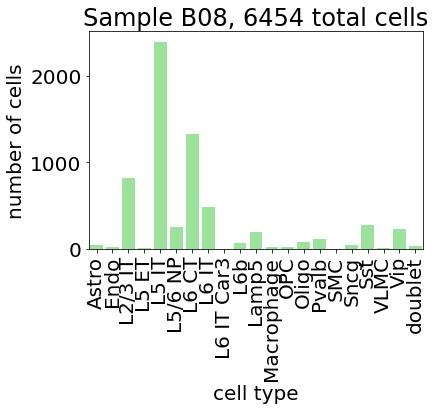

In [181]:
unique_ct = cluster_labels
num_cell_type = []
for ct in unique_ct:
    num_cells = adata[adata.obs['Cell Type']==ct,0].X.todense().shape[0]
    num_cell_type.append(num_cells)
    print(f'There are {num_cells} cells in cell type {ct}!')
    
sns.barplot(x=unique_ct,y = num_cell_type,color = 'lightgreen')
plt.xticks(rotation=90);
plt.xlabel('cell type')
sample = name.split('_')[0]
plt.title(f'Sample {sample}, {adata.shape[0]} total cells')
plt.ylabel('number of cells');

In [230]:
# marker genes for certain genes
unique_ct = cell_types.unique()
ct = 4

cell_type = unique_ct[ct]

# # print out marker genes 
marker_genes = adata[:,adata.var['Marker Annotation'] == ct].var_names.tolist()
print(marker_genes)



# find the most highly expressed spliced in a certain cell type:
total_spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,:].layers['counts'].sum(axis=0)
total_unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,:].layers['counts'].sum(axis=0)



N = 100

total_counts = np.ones((total_spliced_counts.shape[1],2))
total_counts[:,0] = total_unspliced_counts.flatten()
total_counts[:,1] = total_spliced_counts.flatten()
ind_s = np.argpartition(total_counts[:,0], -N)[-N:]
ind_u = np.argpartition(total_counts[:,1], -N)[-N:]

ind_s


KeyError: 'Marker Annotation'

In [486]:
# select gene
#gene = 24
gene_name = 'Rorb'

cell_type = 'L5 IT'
print(f'working with cell type: {cell_type}')
#print(f'working with gene: {adata[1,gene].var.gene_name}')

# subset matrix to get spiced/unspliced counts
spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,adata_u.var['gene_name']==gene_name].layers['counts'].todense()
unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,adata_s.var['gene_name']==gene_name].layers['counts'].todense()

# create matrix of observed counts
observed_counts = np.ones((spliced_counts.shape[0],2))
observed_counts[:,0] = unspliced_counts.flatten()
observed_counts[:,1] = spliced_counts.flatten()


nonzero_u = spliced_counts[unspliced_counts > 0].shape[1]
nonzero_s = spliced_counts[spliced_counts > 0].shape[1]
how_many_cells = len(unspliced_counts)
print(f'There are {how_many_cells} cells in {cell_type} cells')
print(f'There are {nonzero_u} cells in {cell_type} cells with nonzero UNSPLICED counts for this gene')
print(f'There are {nonzero_s} cells in {cell_type} cells with nonzero SPLICED counts for this gene')

working with cell type: L5 IT
There are 2395 cells in L5 IT cells
There are 2170 cells in L5 IT cells with nonzero UNSPLICED counts for this gene
There are 2267 cells in L5 IT cells with nonzero SPLICED counts for this gene


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


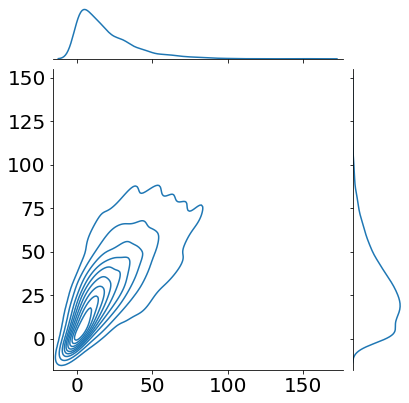

In [487]:
plot = sns.jointplot(observed_counts[:,0], observed_counts[:,1], kind = 'kde')
# plot.ax_marg_x.set_xlim(0, 50)
# plot.ax_marg_y.set_ylim(0, 50)
plt.xlabel('unspliced')
plt.ylabel('spliced');

In [488]:
genes = np.array(adata.var['gene_name'].tolist())

gene = np.where(genes == gene_name)[0][0]


In [489]:
# now, get the log probabilities for each method by AVERAGING PROBABILITIES -- is it different?
x,y = 40,40
x_grid, y_grid = torch.meshgrid(torch.range(0,x), torch.range(0,y))
X = torch.concat((x_grid,y_grid),axis=1)

prob_dict = {}

setups = list(results_dict.keys())
#setups.append('TRUE')

for setup in setups:

    if 'vanilla.full' in setup:
        # vanilla: 
        N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
        mus_u = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
        thetas_u = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]
        mus_s =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
        thetas_s = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene+N]

        mu1 = [torch.ones((x+1,y+1))*mus_u[i] for i in range(len(mus_u))]
        mu2 = [ torch.ones((x+1,y+1))*mus_s[i] for i in range(len(mus_s))]
        theta1 = [torch.ones((x+1,y+1))*thetas_u[i] for i in range(len(thetas_u))]
        theta2 = [torch.ones((x+1,y+1))*thetas_s[i] for i in range(len(thetas_s))]
        theta = [torch.concat((theta1[i],theta2[i]),axis=1) for i in range(len(theta1))]
    
    elif '-' in setup:
        N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
        mus_u = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
        mus_s =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
        thetas = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]
        
        mu1 = [torch.ones((x+1,y+1))*mus_u[i] for i in range(len(mus_u))]
        mu2 = [ torch.ones((x+1,y+1))*mus_s[i] for i in range(len(mus_u))]
        theta = [torch.ones((x+1,y+1))*thetas[i] for i in range(len(thetas_u))]

    if "vanilla" in setup:
        prob = np.array([torch.exp(log_prob_NBuncorr(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])

        prob_dict[setup] = np.sum(prob,axis=0)
        
    elif "Poisson" in setup:
        prob = np.array([torch.exp(log_prob_poisson(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])
        prob_dict[setup] = np.sum(prob,axis=0)
        
    elif "Bursty" in setup:
        prob = np.array([torch.exp(log_prob_nnNB(X.to(torch.device(device)), 
                                   mu1[i].to(torch.device(device)), 
                                   mu2[i].to(torch.device(device)), 
                                   theta[i].to(torch.device(device)), 
                                   eps = 1e-8, THETA_IS = 'NAS_SHAPE')).detach().cpu().numpy()
                                    for i in range(len(mu1))])
        prob_dict[setup] = np.sum(prob,axis=0)
    
    elif "NBcorr" in setup:
        prob = np.array([torch.exp(log_prob_NBcorr(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])
        prob_dict[setup] = np.sum(prob,axis=0)
        
        
    if 'TRUE' in setup:
        print(simulated_params[ct,gene,])
        b, beta, gamma  = 10**simulated_params[ct,gene,:]
        av_mu_u,av_mu_s = b/beta, b/gamma
        av_theta = 1/beta
        theta = [torch.ones((x+1,y+1))*av_theta for i in range(len(mu1))]
        mu1,mu2 = torch.ones((x+1,y+1))*av_mu_u, torch.ones((x+1,y+1))*av_mu_s
        prob = np.array([torch.exp(log_prob_nnNB(X.to(torch.device(device)), 
                                   mu1[i].to(torch.device(device)), 
                                   mu2[i].to(torch.device(device)), 
                                   theta[i].to(torch.device(device)), 
                                   eps = 1e-8, THETA_IS = 'NAS_SHAPE')).detach().cpu().numpy()
                                    for i in range(len(mu1))])
        prob_dict[setup] = np.sum(prob,axis=0)


<ipython-input-489-d34993aa613f>:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x_grid, y_grid = torch.meshgrid(torch.range(0,x), torch.range(0,y))


In [490]:
# hist_dict = {}
# hist_dict['unspliced'] = observed_counts[:,0]
# hist_dict['spliced'] = observed_counts[:,1]
# df_hist = pd.DataFrame(hist_dict)

In [491]:
# sns.displot(data = df_hist, x = 'unspliced', y = 'spliced', palette = sns.color_palette("flare", as_cmap=True))
# plt.xlabel('unspliced')
# plt.ylabel('spliced')
# plt.xlim(0,20)
# plt.ylim(0,20);

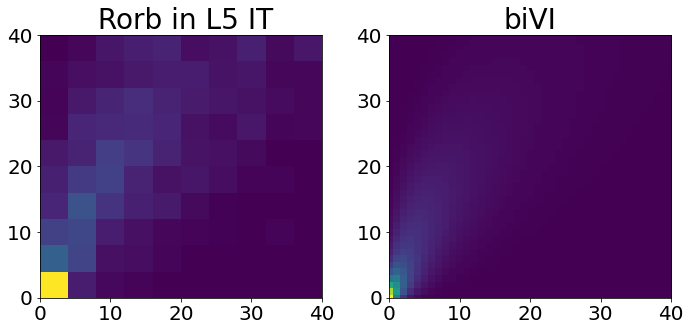

In [498]:
xmin = 0
xmax = 40
ymin = 0
ymax = 40

fs = 28

setups_to_compare = ['Bursty-10-NAS_SHAPE',]
setup_name_change = {'vanilla.full-10-NAS_SHAPE':'scVI','Bursty-10-NAS_SHAPE': 'biVI','TRUE':'True'}

fig, axes = plt.subplots(1,2,figsize=(10,5))
#plt.figure(figsize=(4,4))


ax = axes[0]
ax.set_title(f' {gene_name} in {cell_type}',fontsize=fs)
ax.hist2d(observed_counts[:,0],observed_counts[:,1],bins=(10,10),range = [[xmin,xmax],[ymin,ymax]]);
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.tick_params(axis='both', which='major', labelsize=20)


index = [1]
for i,setup in enumerate(setups_to_compare):
    i = index[i]
    ax = axes[i]
    setup_name = setup_name_change[setup]
    ax.set_title(f'{setup_name}',fontsize=fs)
    ax.imshow(prob_dict[setup].T)
#     forceAspect(ax)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_aspect('auto')


    

plt.tight_layout()

plt.savefig(f'../../results/{name}_figs/distribution_gene{gene_name}_ct{cell_type}.png',bbox_inches = 'tight')

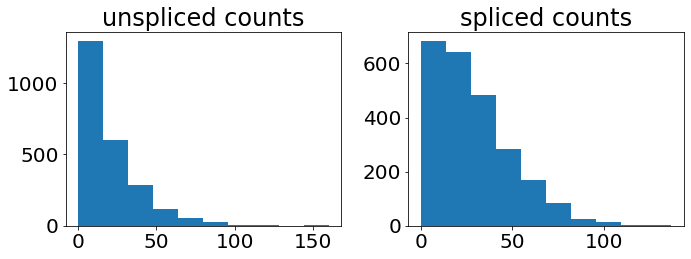

In [480]:
fig, axes = plt.subplots(1,2,figsize =  (10,4))
axes[1].hist(spliced_counts);
axes[1].set_title('spliced counts');
axes[0].set_title('unspliced counts')
axes[0].hist(unspliced_counts);
plt.tight_layout();

-----

# Distribution of Gene Parameters



Distribution of gene parameters for different models, different cell types. 

In [457]:
def get_bursty_params(mu1,mu2,theta):
    ''' Returns b, beta, gamma of bursty distribution given mu1, mu2 and theta.
    Returns whatever size was input. 
    '''
    
    b = mu1/theta
    beta = 1/theta
    gamma = mu1/(mu2*theta)
    
    
    return(b,beta,gamma)


def get_BVNB_params(mu1,mu2,theta):
    ''' Returns splicing rate beta, degradation rate gamma, and alpha (mean of transcription rate distribution) 
    given BVNB extrinsic noise model.
    '''
    alpha = theta
    beta = theta/mu1
    gamma = theta/mu2
    
    
    return(alpha,beta,gamma)

def get_constitutive_params(mu1,mu2):
    ''' Returns rate of splicing rate beta and rate of degradation gamma given constitutive model.
    '''
    beta = 1/mu1
    gamma = 1/mu2
    
    return(beta,gamma)
    

In [458]:
unique_ct

array(['L5 IT', 'L2/3 IT', 'L6 CT', 'L6 IT', 'L6b', 'L5/6 NP', 'Oligo',
       'Pvalb', 'Sst', 'Macrophage', 'Astro', 'Vip', 'doublet', 'Lamp5',
       'Sncg', 'Endo', 'OPC', 'L5 ET', 'SMC', 'VLMC', 'L6 IT Car3'],
      dtype=object)

Look at distributions across cell type.


In [459]:
model = 'bursty'
setup == 'bursty-10-NAS_SHAPE'

ct = 2
cell_type = unique_ct[ct]

N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
mu1 = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
mu2 =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
theta = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]


if model == 'bursty':
    b,beta,gamma = get_bursty_params(mu1,mu2,theta)
elif model == 'constitutive':
    beta,gamma = get_constitutive_params(mu1,mu2)
elif model == 'BVNB':
    alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Cell Type: L6 CT, Gene: 975')

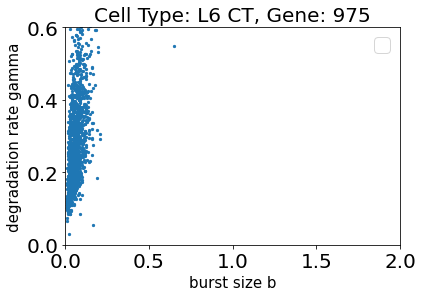

In [460]:
plt.scatter(b,gamma,s=5)
plt.ylabel('degradation rate gamma',fontsize = 15)
plt.xlabel('burst size b', fontsize = 15)
plt.legend()
plt.xlim(0,2.0)
plt.ylim(0,0.6)
plt.title(f'Cell Type: {cell_type}, Gene: {gene}',fontsize = 20)
# NOTE -- beta is going to CONSTANT for ALL CELLS, regardless of cell type. Kinda weird. So the only change we get
# here is from burst size or degradation rate. Limitation, perhaps. 

In [461]:
print(gene_name)

Pter


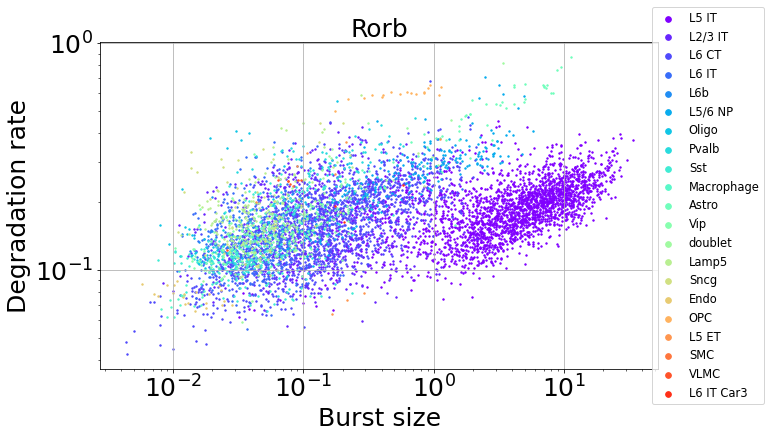

In [473]:
fs = 25
fs_title = 25
model = 'bursty'
setup == 'bursty-10-NAS_SHAPE'

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

# ct = 0
# cell_type = unique_ct[ct]


cm = plt.get_cmap('rainbow')

plt.figure(figsize = (10,6))
for i,cell_type in enumerate(unique_ct):
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    mu1 = results_dict[setup]['params']['mean'][cell_types==cell_type,gene]
    mu2 =  results_dict[setup]['params']['mean'][cell_types==cell_type,gene+N]
    theta = results_dict[setup]['params']['dispersions'][cell_types==cell_type,gene]
    
#     b_true = 10**simulated_params[ct,gene,0]
#     gamma_true = 10**simulated_params[ct,gene,2]
    if model == 'bursty':
        b,beta,gamma = get_bursty_params(mu1,mu2,theta)
    elif model == 'constitutive':
        beta,gamma = get_constitutive_params(mu1,mu2)
    elif model == 'BVNB':
        alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)

    plt.scatter(b,gamma,s=2,label=f'{cell_type}',color=cm(i*12))
#     if i == ct:
#      plt.scatter(b_true,gamma_true,s=400,marker='*',color='k')
    plt.ylabel('Degradation rate',fontsize = fs)
    plt.xlabel('Burst size', fontsize = fs)
    plt.xscale('log')
    plt.yscale('log')
#     plt.xlim(0,2.0)
#     plt.ylim(0,0.6)
plt.legend(loc='center right',bbox_to_anchor=(1.2, 0.5),fontsize = 11.5,markerscale=4.)
plt.title(f'{gene_name}',fontsize = fs_title)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.grid()
ax.yaxis.set_major_formatter(formatter) 

plt.savefig(f'../../results/{name}_figs/marker_gene_params_gene{gene_name}.png',bbox_inches = 'tight')
# NOTE -- beta is going to CONSTANT for ALL CELLS, regardless of cell type. Kinda weird. So the only change we get
# here is from burst size or degradation rate. Limitation, perhaps. 

In [272]:
adata

AnnData object with n_obs × n_vars = 6454 × 4000
    obs: 'Cell Type', 'barcode', 'class_label', 'cluster_id', 'cluster_label', 'obs_names', 'subclass_label'
    var: 'Spliced', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_name', 'highly_variable', 'means', 'var_names'
    layers: 'counts'